In [1]:
!nvidia-smi

Thu Sep 28 18:08:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#Install Grounding Dino

!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.2 MB/s eta 0:00:00


In [7]:
import os

CONFIG_PATH = os.path.join("/content", "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [8]:

import os
HOME = os.getcwd()
print(HOME)

/content/GroundingDINO


In [9]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content/GroundingDINO
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 401 (delta 51), reused 44 (delta 44), pack-reused 325
Receiving objects: 100% (401/401), 12.84 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/GroundingDINO/GroundingDINO
  Preparing metadata (setup.py) ... done


In [10]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/GroundingDINO
/content/GroundingDINO/weights
/content/GroundingDINO/weights/groundingdino_swint_ogc.pth ; exist: True


In [11]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content/GroundingDINO
/content/GroundingDINO/data


In [12]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


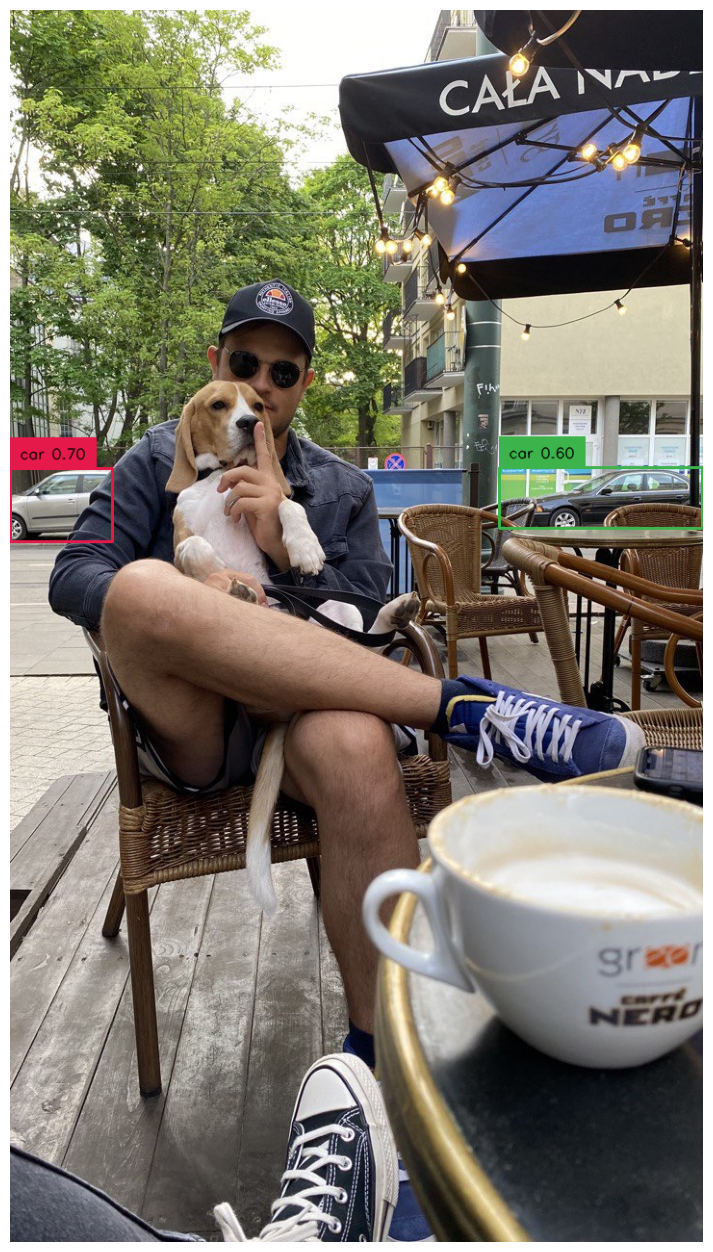

In [14]:
import os
import supervision as sv

IMAGE_NAME = "dog-3.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "car"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [16]:
logits

tensor([0.6962, 0.6031])

In [17]:
phrases

['car', 'car']

In [23]:
import roboflow

roboflow.login()


from random import randrange
from roboflow.core.dataset import Dataset


def pick_random_image(dataset: Dataset, subdirrectory: str = "valid") -> str:
    image_directory_path = f"{dataset.location}/{subdirrectory}"
    image_names = os.listdir(image_directory_path)
    image_index = randrange(len(image_names))
    image_name = image_names[image_index]
    image_path = os.path.join(image_directory_path, image_name)
    return image_path


from roboflow import Roboflow
rf = Roboflow()
project = rf.workspace("work-safe-project").project("safety-vest---v4")
dataset = project.version(3).download("coco")


visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Safety-vest---v4-3 in coco:: 100%|██████████| 438/438 [00:00<00:00, 3977.17it/s]


In [24]:
TEXT_PROMPT = ", ".join(project.classes.keys())
TEXT_PROMPT

'reflective, not_helmet, helmet, not_reflective'

In [27]:
image_path = pick_random_image(dataset=dataset)
image_path

'/content/GroundingDINO/GroundingDINO/Safety-vest---v4-3/valid/00634_jpg.rf.8c6450c804dac57f3a15e98870cab41f.jpg'

The `device` argument is deprecated and will be removed in v5 of Transformers.
None of the inputs have requires_grad=True. Gradients will be None


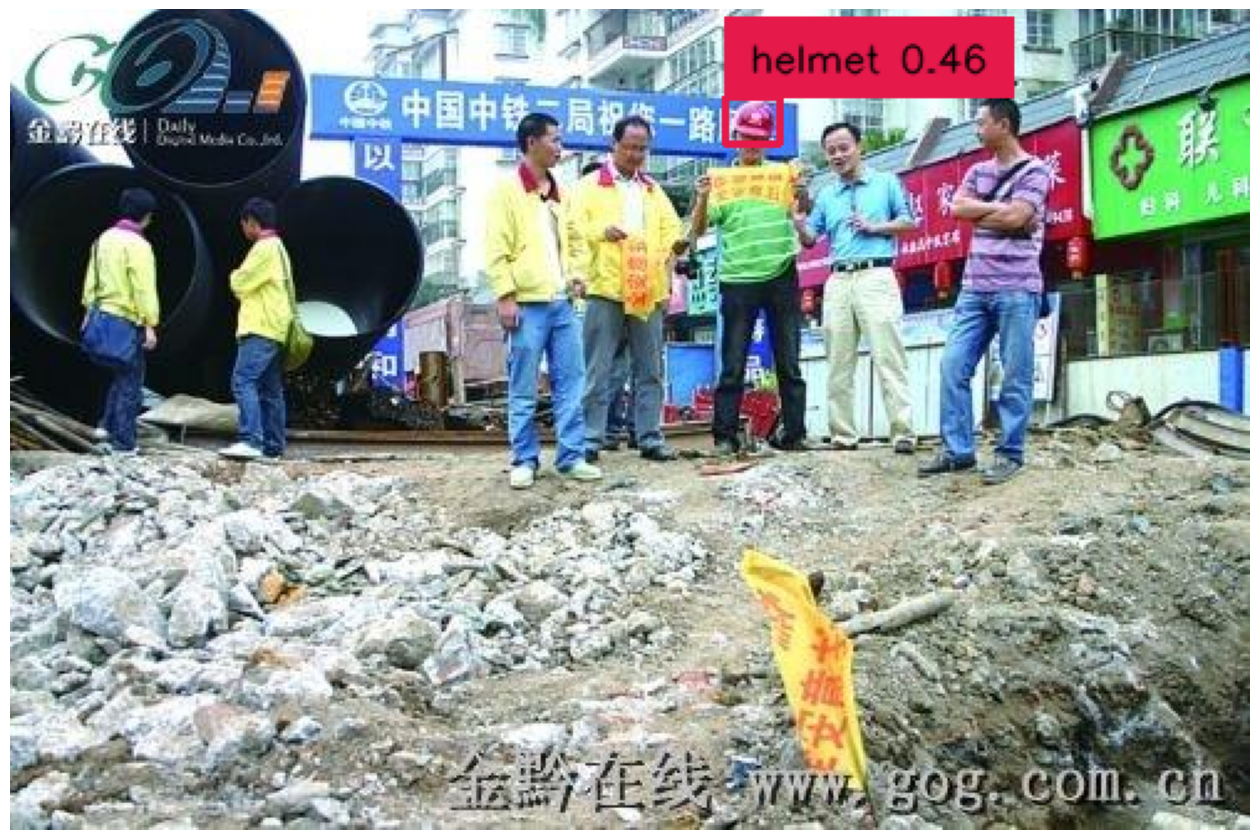

In [28]:
import os
import supervision as sv

BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(image_path)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))
